<a href="https://colab.research.google.com/github/Gayeon6423/BusinessAI-Capston/blob/main/predict_%EC%A0%95%EA%B0%80%EC%97%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# from google.colab import drive
# drive.mount("/content/drive")

In [ ]:
import os
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras import optimizers
from tensorflow.keras.layers import LSTM, Dropout, Dense, Conv1D, MaxPooling1D, Flatten
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import Dropout, Flatten,TimeDistributed
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# stock_data = pd.read_csv('/content/drive/MyDrive/산업 AI 캡스톤/DATA/Total_Data/Final_Feature_kospi_sen_all.csv')
stock_data = pd.read_csv('../../DATA/Total_Data/Final_Feature_kospi_sen_all.csv')
stock_data

,Date,Kospi_close,Kospi_high,ko_interest,oil_open,ex_JP_low,gold_low,us500_low,klue_bert_score_summarize_content,oil_vol,research_kospi,dji_vol,us500_vol,kofinbert_score_summarize_content_kospi,kofinbert_score_title_kospi,klue_bert_score_title
0,20210105,2990.57,0.795,0.0,0.213,0.590,0.661,0.581,-0.536,0.013,0.413,0.280,0.349,0.157,0.195,0.823
1,20210106,2968.21,0.819,0.0,0.219,0.596,0.650,0.585,1.381,0.006,0.628,0.470,0.527,1.236,0.569,0.722
2,20210107,3031.68,0.839,0.0,0.225,0.597,0.670,0.608,1.845,0.007,0.427,0.378,0.410,0.537,1.395,-0.675
3,20210108,3152.18,0.855,0.0,0.230,0.584,0.631,0.615,2.497,0.004,0.512,0.318,0.371,0.697,-1.382,1.124
4,20210111,3148.45,0.914,0.0,0.232,0.584,0.623,0.617,-0.951,0.009,0.881,0.287,0.334,0.331,-0.044,0.730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,20230623,2570.10,0.601,1.0,0.651,0.028,0.212,0.830,0.402,0.000,0.125,0.316,0.526,0.834,-0.339,0.831
584,20230626,2582.20,0.602,1.0,0.651,0.024,0.212,0.825,-0.385,0.000,0.120,0.170,0.207,-0.196,0.681,-0.001
585,20230627,2581.39,0.594,1.0,0.651,0.000,0.208,0.828,-0.447,0.000,0.118,0.206,0.226,-0.208,0.625,-0.097
586,20230628,2564.19,0.592,1.0,0.651,0.011,0.217,0.838,0.777,0.000,0.128,0.174,0.246,1.099,0.892,0.253


In [ ]:
# 데이터 전처리
data = stock_data['Kospi_close'].values.reshape(-1, 1)
stock_data = stock_data.drop(['Kospi_close'],axis=1)
stock_data = stock_data.drop(['Date'],axis=1)

In [ ]:
name = [stock_data.columns]

close_1 = ['kofinbert_score_summarize_content_kospi',
        'kofinbert_score_title_kospi',
        'klue_bert_score_title']

close_2 = ['kofinbert_score_summarize_content_kospi',
        'kofinbert_score_title_kospi',
        'klue_bert_score_summarize_content']

stock_data_1 = stock_data.drop(close_1, axis=1)
stock_data_2 = stock_data.drop(close_2, axis=1)

In [ ]:
# 데이터 분할
train_size = int(len(data) * 0.85)
train_data, test_data = data[:train_size], data[train_size:]
train_data_t_1, test_data_t_1 = stock_data_1[:train_size], stock_data_1[train_size:]
train_data_t_2, test_data_t_2 = stock_data_2[:train_size], stock_data_2[train_size:]

def create_dataset(dataset, data, look_back=10):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(dataset[i:(i + look_back)])
        y.append(data[i + look_back])
    return np.array(X), np.array(y)

look_back = 5  # 몇 일 동안의 데이터를 사용할 것인지 설정

trainX, trainY = create_dataset(train_data_t_1, train_data, look_back)
testX, testY = create_dataset(test_data_t_1,test_data, look_back)
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(494, 5, 11)
(494, 1)
(84, 5, 11)
(84, 1)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_6 (GRU)                 (None, 5, 1024)           3185664   
                                                                 
 dropout_6 (Dropout)         (None, 5, 1024)           0         
                                                                 
 gru_7 (GRU)                 (None, 5, 512)            2362368   
                                                                 
 dropout_7 (Dropout)         (None, 5, 512)            0         
                                                                 
 gru_8 (GRU)                 (None, 5, 256)            591360    
                                                                 
 dropout_8 (Dropout)         (None, 5, 256)            0         
                                                                 
 gru_9 (GRU)                 (None, 5, 128)           

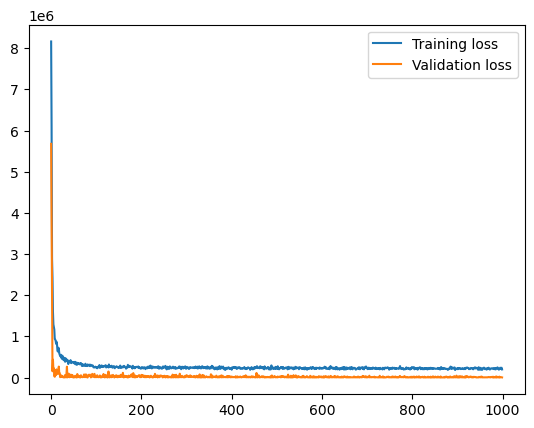

3/3 [==============================] - 0s 32ms/step
Training MSE: 12211.249634615597
Testing MSE: 3188.310772028793


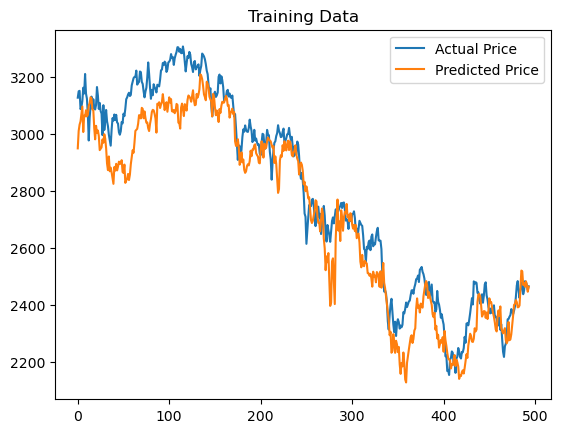

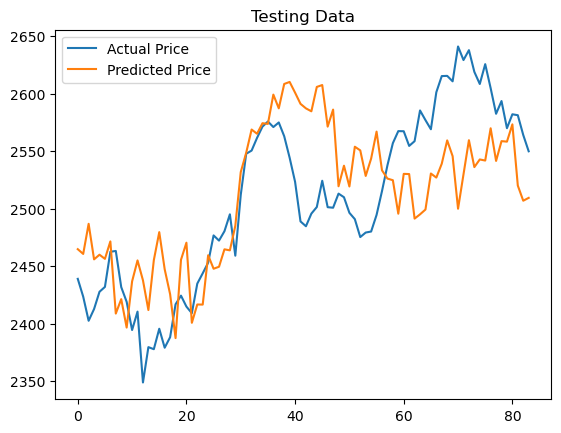

In [ ]:
# 모델 생성 GRU, klue_bert_score_summarize_content
model = Sequential()
model.add(GRU(units=1024, activation='relu', return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.3))
model.add(GRU(units=512, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(units=256, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(units=128, activation='relu',return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(units=64, activation='relu',return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(units=32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=1))
model.summary()

# loss = Huber()
# optimizer = Adam(0.0005)
# model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])
model.compile(optimizer='adam', loss='mean_squared_error')

filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename,
                             save_weights_only=True,
                             save_best_only=True,
                             monitor='val_loss',
                             verbose=1)

# 모델 학습
history = model.fit(trainX, trainY, epochs=1000, batch_size=64,
          validation_split=0.1, verbose=2, callbacks=[checkpoint])

model.save_weights('./klue_sum_GRU_weights.h1')

model.load_weights(filename)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

# 예측
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# MSE 계산
trainMSE = mean_squared_error(trainY, trainPredict)
testMSE = mean_squared_error(testY, testPredict)

print(f'Training MSE: {trainMSE}')
print(f'Testing MSE: {testMSE}')

# 예측 시각화
plt.plot(trainY, label='Actual Price')
plt.plot(trainPredict, label='Predicted Price')
plt.legend()
plt.title('Training Data')
plt.show()

plt.plot(testY, label='Actual Price')
plt.plot(testPredict, label='Predicted Price')
plt.legend()
plt.title('Testing Data')
plt.show()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 3, 256)            8704      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1, 256)           0         
 )                                                               
                                                                 
 gru_12 (GRU)                (None, 1, 1024)           3938304   
                                                                 
 dropout_12 (Dropout)        (None, 1, 1024)           0         
                                                                 
 gru_13 (GRU)                (None, 1, 512)            2362368   
                                                                 
 dropout_13 (Dropout)        (None, 1, 512)            0         
                                                      

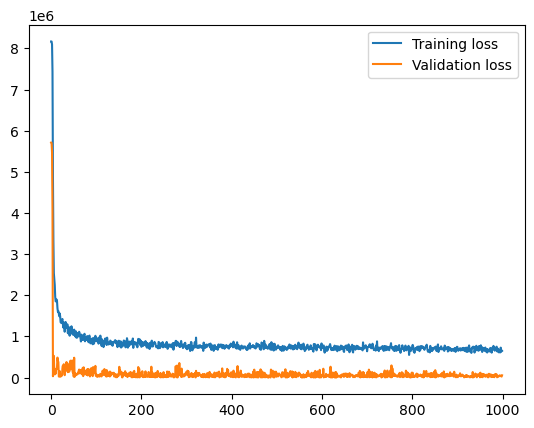

3/3 [==============================] - 0s 12ms/step
Training MSE: 5834.59018555069
Testing MSE: 2288.9338538169004


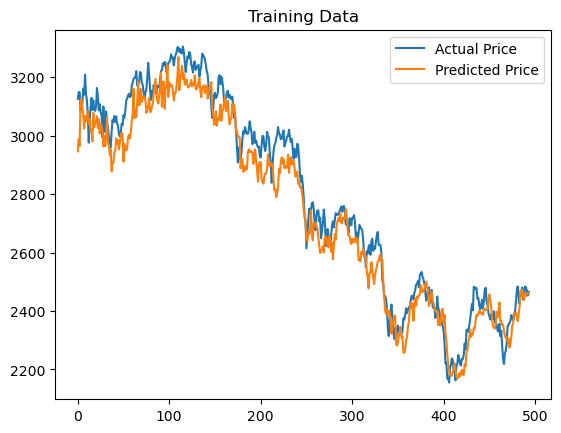

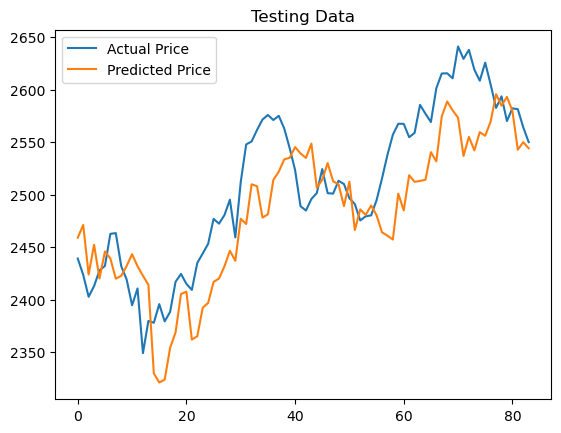

In [ ]:
# 모델 생성 GRU+CNN, klue_bert_score_summarize_content
model = Sequential()
model.add(Conv1D(filters=256, kernel_size=3, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(GRU(units=1024, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(units=512, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(units=256, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(units=128, activation='relu',return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(units=64, activation='relu',return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(units=32, activation='relu',return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(units=16, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=1))
model.summary()


# loss = Huber()
# optimizer = Adam(0.0005)
# model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])
model.compile(optimizer='adam', loss='mean_squared_error')

filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename,
                             save_weights_only=True,
                             save_best_only=True,
                             monitor='val_loss',
                             verbose=1)

# 모델 학습
history = model.fit(trainX, trainY, epochs=1000, batch_size=64,
          validation_split=0.1, verbose=2,callbacks=[checkpoint])

model.save_weights('./klue_sum_CNN_GRU_weights.h2')

model.load_weights(filename)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

# 예측
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# MSE 계산
trainMSE = mean_squared_error(trainY, trainPredict)
testMSE = mean_squared_error(testY, testPredict)

print(f'Training MSE: {trainMSE}')
print(f'Testing MSE: {testMSE}')

# 예측 시각화
plt.plot(trainY, label='Actual Price')
plt.plot(trainPredict, label='Predicted Price')
plt.legend()
plt.title('Training Data')
plt.show()

plt.plot(testY, label='Actual Price')
plt.plot(testPredict, label='Predicted Price')
plt.legend()
plt.title('Testing Data')
plt.show()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 3, 256)            8704      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1, 256)           0         
 1D)                                                             
                                                                 
 lstm (LSTM)                 (None, 1, 1024)           5246976   
                                                                 
 dropout_19 (Dropout)        (None, 1, 1024)           0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 512)            3147776   
                                                                 
 dropout_20 (Dropout)        (None, 1, 512)            0         
                                                      

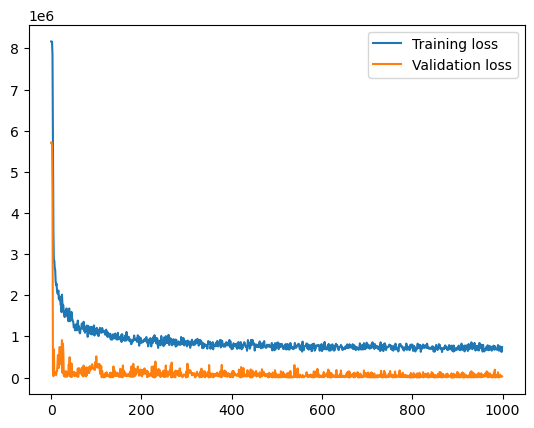

3/3 [==============================] - 0s 13ms/step
Training MSE: 19904.328837531164
Testing MSE: 2197.5903734394474


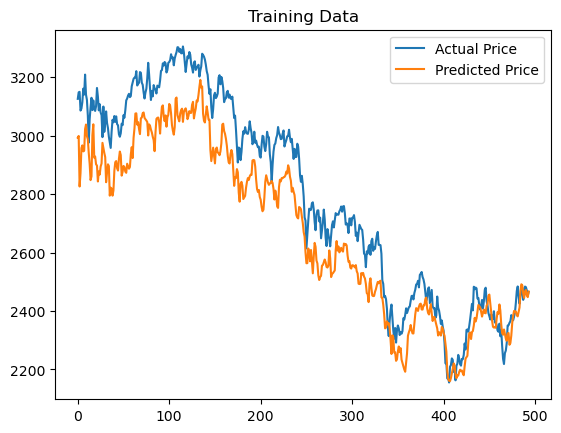

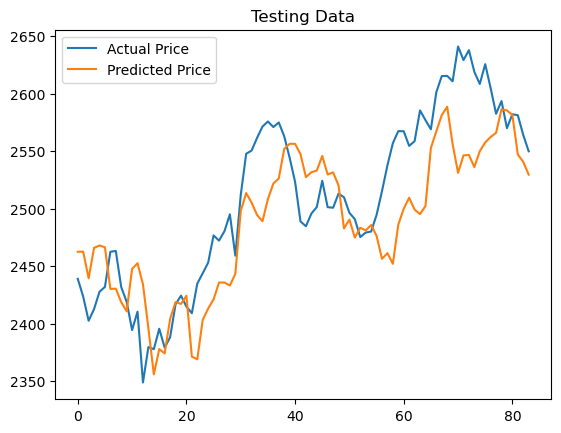

In [ ]:
# 모델 생성 CNN+ LSTM, klue_bert_score_summarize_content
model = Sequential()
model.add(Conv1D(filters=256 , kernel_size=3, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(units=1024, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=512, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=256, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=128, activation='relu',return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=64, activation='relu',return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=32, activation='relu',return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=16, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=1))
model.summary()

# loss = Huber()
# optimizer = Adam(0.0005)
# model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

model.compile(optimizer='adam', loss='mean_squared_error')

filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename,
                             save_weights_only=True,
                             save_best_only=True,
                             monitor='val_loss',
                             verbose=1)

# 모델 학습
history = model.fit(trainX, trainY, epochs=1000, batch_size=64,
          validation_split=0.1, verbose=2,callbacks=[checkpoint])

model.save_weights('./klue_sum_LSTM_weights.h3')

model.load_weights(filename)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

# 예측
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# MSE 계산
trainMSE = mean_squared_error(trainY, trainPredict)
testMSE = mean_squared_error(testY, testPredict)

print(f'Training MSE: {trainMSE}')
print(f'Testing MSE: {testMSE}')

# 예측 시각화
plt.plot(trainY, label='Actual Price')
plt.plot(trainPredict, label='Predicted Price')
plt.legend()
plt.title('Training Data')
plt.show()

plt.plot(testY, label='Actual Price')
plt.plot(testPredict, label='Predicted Price')
plt.legend()
plt.title('Testing Data')
plt.show()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 5, 1024)           4243456   
                                                                 
 dropout_26 (Dropout)        (None, 5, 1024)           0         
                                                                 
 lstm_8 (LSTM)               (None, 5, 512)            3147776   
                                                                 
 dropout_27 (Dropout)        (None, 5, 512)            0         
                                                                 
 lstm_9 (LSTM)               (None, 5, 256)            787456    
                                                                 
 dropout_28 (Dropout)        (None, 5, 256)            0         
                                                                 
 lstm_10 (LSTM)              (None, 5, 128)           

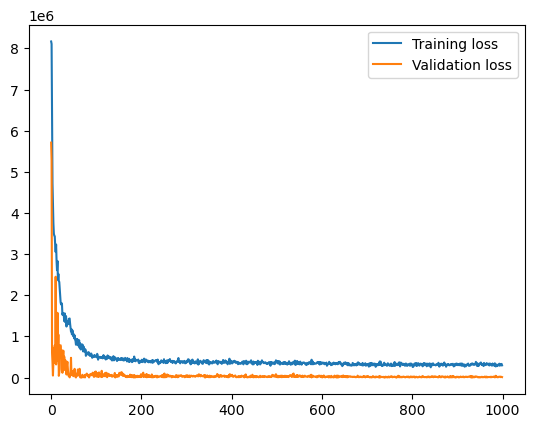

3/3 [==============================] - 0s 36ms/step
Training MSE: 12652.798395027425
Testing MSE: 5207.678198240709


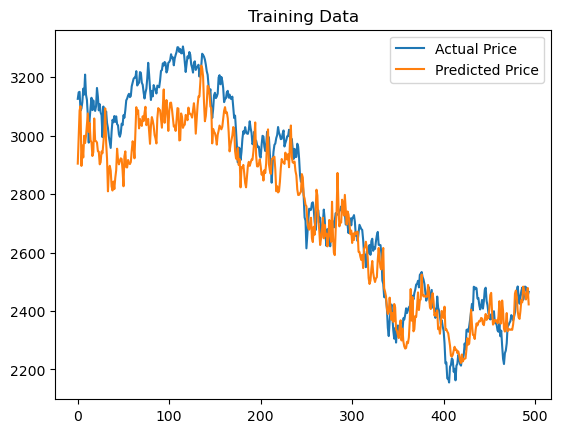

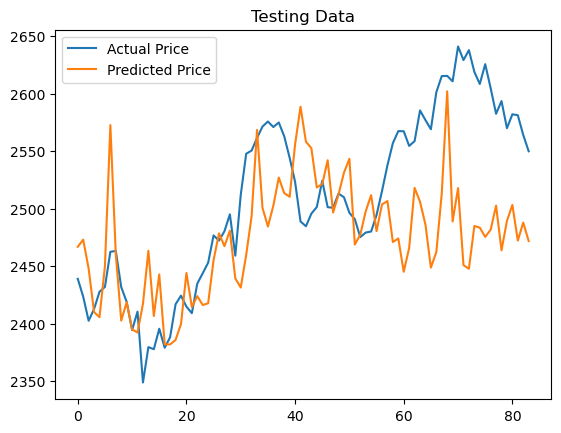

In [ ]:
# 모델 생성 LSTM, klue_bert_score_summarize_content
model = Sequential()
model.add(LSTM(units=1024, activation='relu', return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(units=512, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=256, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=128, activation='relu',return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=64, activation='relu',return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=32, activation='relu',return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=16, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=1))
model.summary()

# loss = Huber()
# optimizer = Adam(0.0005)
# model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

model.compile(optimizer='adam', loss='mean_squared_error')

filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename,
                             save_weights_only=True,
                             save_best_only=True,
                             monitor='val_loss',
                             verbose=1)

# 모델 학습
history = model.fit(trainX, trainY, epochs=1000, batch_size=64,
          validation_split=0.1, verbose=2,callbacks=[checkpoint])

model.save_weights('./klue_sum_CNN_LSTM_weights.h3')

model.load_weights(filename)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

# 예측
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# MSE 계산
trainMSE = mean_squared_error(trainY, trainPredict)
testMSE = mean_squared_error(testY, testPredict)

print(f'Training MSE: {trainMSE}')
print(f'Testing MSE: {testMSE}')

# 예측 시각화
plt.plot(trainY, label='Actual Price')
plt.plot(trainPredict, label='Predicted Price')
plt.legend()
plt.title('Training Data')
plt.show()

plt.plot(testY, label='Actual Price')
plt.plot(testPredict, label='Predicted Price')
plt.legend()
plt.title('Testing Data')
plt.show()

In [ ]:
trainX, trainY = create_dataset(train_data_t_2, train_data, look_back)
testX, testY = create_dataset(test_data_t_2,test_data, look_back)

print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(494, 5, 11)
(494, 1)
(84, 5, 11)
(84, 1)


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 5, 1024)           4243456   
                                                                 
 dropout_33 (Dropout)        (None, 5, 1024)           0         
                                                                 
 lstm_15 (LSTM)              (None, 5, 512)            3147776   
                                                                 
 dropout_34 (Dropout)        (None, 5, 512)            0         
                                                                 
 lstm_16 (LSTM)              (None, 5, 256)            787456    
                                                                 
 dropout_35 (Dropout)        (None, 5, 256)            0         
                                                                 
 lstm_17 (LSTM)              (None, 5, 128)           

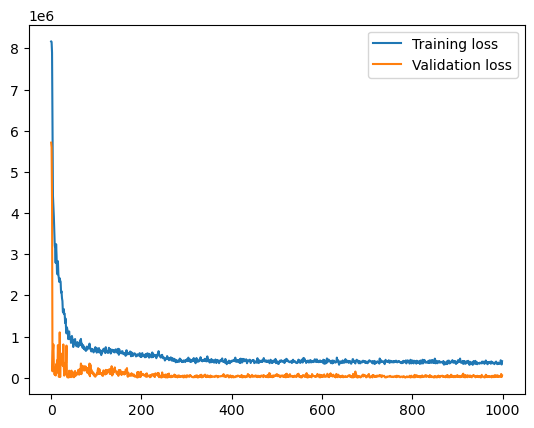

3/3 [==============================] - 0s 31ms/step
Training MSE: 19393.12449643748
Testing MSE: 18463.722360871056


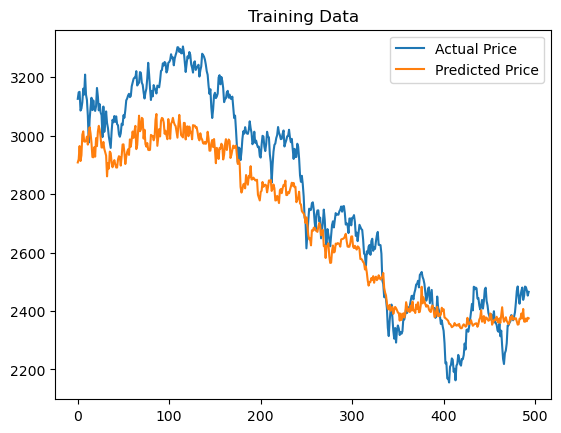

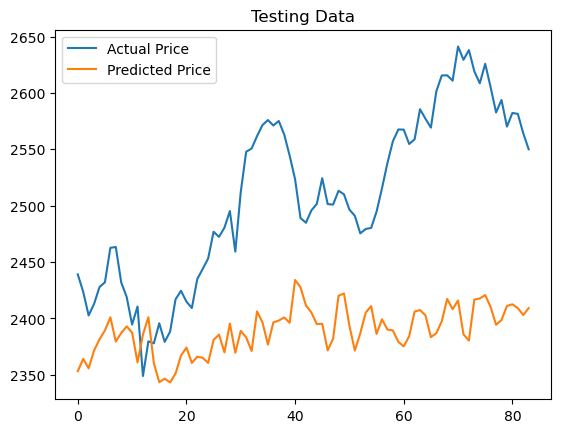

In [ ]:
# 모델 생성 LSTM, klue_bert_score_title
model = Sequential()
model.add(LSTM(units=1024, activation='relu', return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(units=512, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=256, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=128, activation='relu',return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=64, activation='relu',return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=32, activation='relu',return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=16, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=1))
model.summary()

# loss = Huber()
# optimizer = Adam(0.0005)
# model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

model.compile(optimizer='adam', loss='mean_squared_error')

filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename,
                             save_weights_only=True,
                             save_best_only=True,
                             monitor='val_loss',
                             verbose=1)

# 모델 학습
history = model.fit(trainX, trainY, epochs=1000, batch_size=64,
          validation_split=0.1, verbose=2,callbacks=[checkpoint])

model.save_weights('./klue_t_LSTM_weights.h3')

model.load_weights(filename)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

# 예측
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# MSE 계산
trainMSE = mean_squared_error(trainY, trainPredict)
testMSE = mean_squared_error(testY, testPredict)

print(f'Training MSE: {trainMSE}')
print(f'Testing MSE: {testMSE}')

# 예측 시각화
plt.plot(trainY, label='Actual Price')
plt.plot(trainPredict, label='Predicted Price')
plt.legend()
plt.title('Training Data')
plt.show()

plt.plot(testY, label='Actual Price')
plt.plot(testPredict, label='Predicted Price')
plt.legend()
plt.title('Testing Data')
plt.show()